# **Lorem ipsum dolor sit amet, consectetur adipiscing elit.**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur tempor magna sed arcu sagittis bibendum. Phasellus accumsan et diam sit amet dictum. Phasellus scelerisque bibendum ex a malesuada. Vivamus auctor libero eget lacus venenatis aliquam. Aenean elementum eros vel ex finibus tincidunt. Pellentesque ut leo sapien. Quisque sodales, elit eu malesuada aliquet, erat risus gravida ipsum, ac aliquet libero mauris in lorem. Nulla facilisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos.

**Authors:**
- [Andrea Ramírez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **Import Libraries** ⬇️

In [1]:
#!pip install keras-tuner

In [2]:
#%pip install kaggle

In [3]:
#!pip install opendatasets

In [4]:
# Standard libraries
import os
import zipfile
import shutil
import warnings
import itertools
from operator import concat
from PIL import Image
import cv2

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow import keras
import opendatasets as od

# Suppress warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (10, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

# Set TensorFlow Global Seed
tf.random.set_seed(random_state)

## **Data Upload** 📄

In [5]:
# Check if the directory 'mnist-multiple-dataset-comprehensive-analysis' exists
if not os.path.isdir('mnist-multiple-dataset-comprehensive-analysis'):
    # If the directory doesn't exist, download the dataset from Kaggle
    od.download("https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis?resource=download")
else:
    # If the directory exists, copy the contents of 'train' into '../Scripts/mnist-dataset/train'
    train_src = 'mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train'
    train_dst = '../Scripts/mnist-dataset/train'
    if not os.path.exists(train_dst):
        shutil.copytree(train_src, train_dst)

    # Copy the contents of 'test' into '../Scripts/mnist-dataset/test'
    test_src = 'mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test'
    test_dst = '../Scripts/mnist-dataset/test'
    if not os.path.exists(test_dst):
        shutil.copytree(test_src, test_dst)

In [6]:
def load_images_with_labels(directory):
    """
    Load images and their labels from the specified directory and its subdirectories.

    Parameters:
    - directory (str): Path to the main directory containing subdirectories with images.

    Returns:
    - List of tuples: Each tuple contains the image path and its corresponding label.
    """
    image_label_pairs = []

    # List all subdirectories in the directory
    subdirs = [os.path.join(directory, subdir) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]

    for subdir in subdirs:
        # Collect all image files in the current subdirectory
        all_files = os.listdir(subdir)
        image_files = [os.path.join(subdir, f) for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # Extract label from the image filename (remove extension)
        for image_file in image_files:
            label = os.path.splitext(os.path.basename(image_file))[0]
            label = label.split('.')[1]
            image_label_pairs.append((image_file, label))

    return image_label_pairs

In [7]:
def load_and_display_images_with_labels(directory, num_images=5):
    """
    Load and display a sample of images with their labels from the specified directory and its subdirectories.

    Parameters:
    - directory (str): Path to the main directory containing subdirectories with images.
    - num_images (int): Number of images to display.
    """
    # Load image-label pairs
    image_label_pairs = load_images_with_labels(directory)

    # Display a sample of images
    for i, (image_file, label) in enumerate(image_label_pairs[:num_images]):
        with Image.open(image_file) as img:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label {label}")
            plt.axis('off')

    plt.show()
    return image_label_pairs

Displaying training images...


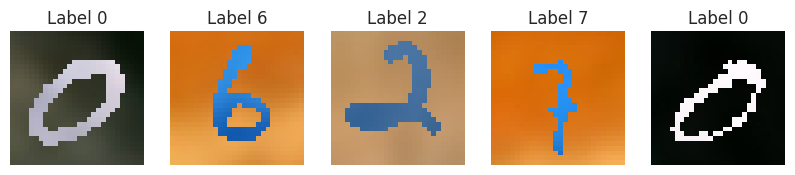

Displaying test images...


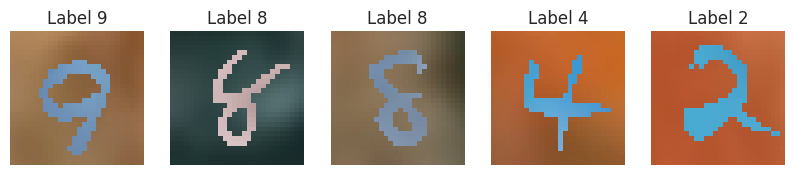

In [8]:
# Define paths to the train and test directories
train_dir = '../Scripts/mnist-dataset/train'
test_dir = '../Scripts/mnist-dataset/test'

# Load and display images from the train directory
print("Displaying training images...")
train = load_and_display_images_with_labels(train_dir)

# Load and display images from the test directory
print("Displaying test images...")
test = load_and_display_images_with_labels(test_dir)

**Observaciones 💡 -->**

> - El conjunto de datos MNIST Multiple Dataset for Comprehensive Analysis se ha obtenido desde la página oficial de [Kaggle](https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis?resource=download). En particular, se ha utilizado la variante PolyMNIST, que incluye cinco modalidades distintas. En cada modalidad, el fondo está compuesto por parches aleatorios extraídos de una imagen más grande, con un dígito colocado de manera aleatoria dentro de estos parches. Esta configuración proporciona a cada modalidad información única del fondo, mientras que el dígito actúa como información compartida entre todas las modalidades.

> - Como se puede observar en los resultados del código anterior, todas las imágenes tienen la misma resolución, así que no se deben de modificar en este aspecto.

## **Exploratory Analysis** 🔎

In [9]:
# Example of converting lists of tuples to DataFrames
def convert_to_dataframe(data_list):
    # Create lists to hold images and labels
    images = []
    labels = []

    # Iterate through the list of tuples
    for image, label in data_list:
        images.append(image)
        labels.append(label)

    # Convert lists to DataFrame
    df = pd.DataFrame({
        'image': images,
        'label': labels
    })

    return df

In [10]:
# Convert the train and test lists to DataFrames
dataframes = [convert_to_dataframe(train), convert_to_dataframe(test)]

In [11]:
# Display the DataFrames
for i, df in enumerate(dataframes):
  print("Training DataFrame:" if i == 0 else "Test DataFrame:")
  print(df.head(), "\n")

Training DataFrame:
                                          image label
0  ../Scripts/mnist-dataset/train/m1/4243.0.png     0
1  ../Scripts/mnist-dataset/train/m1/2757.6.png     6
2  ../Scripts/mnist-dataset/train/m1/2130.2.png     2
3  ../Scripts/mnist-dataset/train/m1/2896.7.png     7
4  ../Scripts/mnist-dataset/train/m1/1528.0.png     0 

Test DataFrame:
                                        image label
0   ../Scripts/mnist-dataset/test/m1/10.9.png     9
1  ../Scripts/mnist-dataset/test/m1/812.8.png     8
2  ../Scripts/mnist-dataset/test/m1/970.8.png     8
3  ../Scripts/mnist-dataset/test/m1/240.4.png     4
4  ../Scripts/mnist-dataset/test/m1/546.2.png     2 



### **(1) Exploración y Limpieza Inicial de los Datos**

In [12]:
for i, df in enumerate(dataframes):
    # Get the number of rows in the DataFrame
    rows_num = df.shape[0]
    # Print the number of records in the DataFrame
    print(f"{'Training DataFrame:' if i == 0 else 'Test DataFrame:'} has {rows_num} records.")

Training DataFrame: has 300000 records.
Test DataFrame: has 50000 records.


**Observaciones 💡 -->**

> - El primer conjunto de datos, el que será utilizado para el **entrenamiento** del modelo, cuenta con alrededor de 300.000 registros y 2 columnas.
> - El primer conjunto de datos, el que será utilizado para el **testeo** del modelo, cuenta con alrededor de 50.000 registros y 2 columnas.

In [13]:
for df in dataframes:
  # Basic information about the dataset
  print(df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   image   300000 non-null  object
 1   label   300000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None 



In [14]:
for df in dataframes:
  # Basic information about the dataset
  df['label'] = df['label'].astype(int)

### **(2) Clasificación de las Variables**

| Nombre | Descripción                                                                 | Tipo               |
|--------|-----------------------------------------------------------------------------|--------------------|
| image  | Contiene las imágenes de dígitos en formato de objeto.| Categórica (Descriptiva) |
| label  | Contiene las etiquetas asociadas a cada imagen, que representan el dígito correspondiente en formato de objeto. | Categórica (Descriptiva) |

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Distribución de Labels**

In [15]:
def labelDistribution(df, name):
  label_counts = df['label'].value_counts().sort_index()
  total_counts = label_counts.sum()

  # Calculate percentages
  label_percentages = (label_counts / total_counts) * 100
  # Plot counts
  plt.subplot(1, 2, 1)
  label_counts.plot(kind='bar', color=palette[0])
  plt.title(f'{name}: Label Counts')
  plt.xlabel('Label')
  plt.ylabel('Count')

  # Plot percentages
  plt.subplot(1, 2, 2)
  label_percentages.plot(kind='bar', color=palette[4])
  plt.title(f'{name}: Label Percentages')
  plt.xlabel('Label')
  plt.ylabel('Percentage (%)')

  plt.tight_layout()
  plt.show()

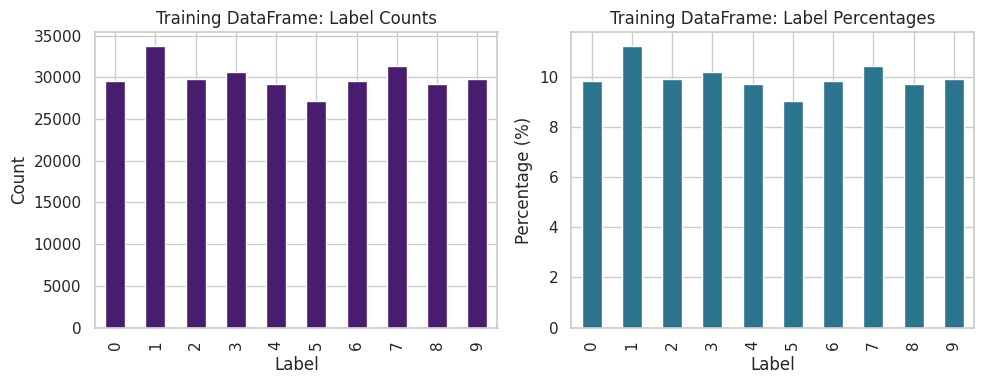

In [16]:
labelDistribution(dataframes[0], "Training DataFrame")

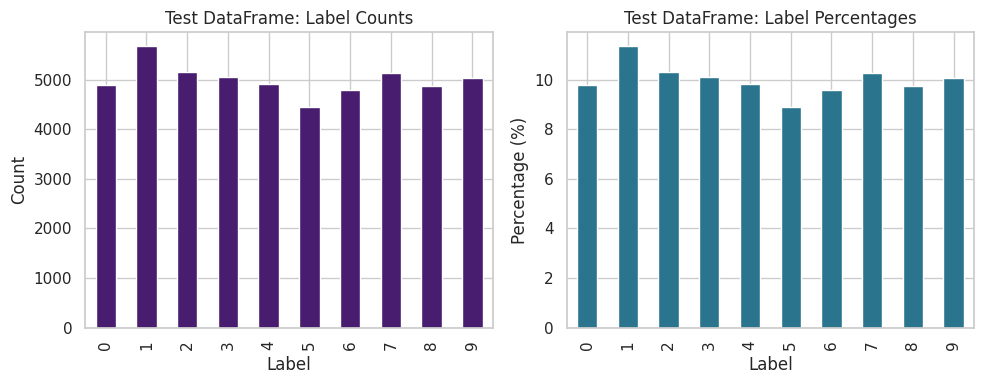

In [17]:
labelDistribution(dataframes[1], "Test DataFrame")

**Observaciones 💡 -->**

test test

#### **(2) Tamaños de Imagenes**

In [18]:
 # Get unique image sizes
for i, df in enumerate(dataframes):
  # Extract image sizes
  sizes = df['image'].apply(lambda path: Image.open(path).size if isinstance(path, str) else (None, None))
  # Count unique sizes
  size_counts = sizes.value_counts()
  print(f'Training DataFrame:' if i == 0 else 'Test DataFrame:')
  for size, count in size_counts.items():
    print(f'Size {size}: Count = {count}')
    print()

Training DataFrame:
Size (28, 28): Count = 300000

Test DataFrame:
Size (28, 28): Count = 50000



**Observaciones 💡 -->**

Test test

## **Image Preprocessing 📷**

In [19]:
def preprocess_image(image_path, taget_size = 28):
    # Read the image from the file
    img = cv2.imread(image_path)
    # Convert the image to grayscale (if required by your model)
    # If your CNN expects color images, skip this step
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Reason: Convert to grayscale if the model is designed for single-channel input.
    # Normalize pixel values to the range [0, 1]
    img = img / 255.0
    # Reason: Normalization ensures that pixel values are in a consistent range, helping the CNN learn more effectively.
    # Apply Gaussian blur to reduce noise (optional, depending on the noise level in your images)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Reason: Noise reduction can help the CNN by removing small details that may not be useful for learning.
    img = np.expand_dims(img, axis=-1)
    # Reason: Consistent image size is required for CNN input.

    return img

In [20]:
# Put labels into y_train variable
y_train = dataframes[0]['label']
# Drop 'label' column
x_train = dataframes[0].drop(labels = ['label'], axis = 1)

In [21]:
# Drop 'label' column
test_df = dataframes[1].drop(labels = ['label'], axis = 1)

In [22]:
# Apply the function
x_train['image'] = x_train['image'].apply(preprocess_image)

In [23]:
# Apply the function
test_df['image'] = test_df['image'].apply(preprocess_image)

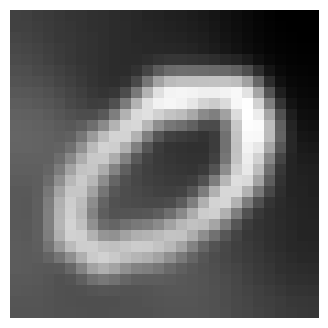

In [24]:
image = x_train['image'][0]  # Select the first image
# Display the image
plt.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide axis labels
plt.show()

In [27]:
# Label Encoding
from keras.utils import to_categorical # Convert to one-hot-encoding

y_train = to_categorical(y_train, num_classes = 10)

In [28]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## **Model Generation**

In [29]:
x_train_reshape = np.array([np.array(img) for img in x_train['image']])
test_reshape = np.array([np.array(img) for img in test_df['image']])

In [30]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train_reshape, y_train, test_size = 0.2, random_state = random_state)

In [31]:
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (240000, 28, 28, 1)
x_test shape (60000, 28, 28, 1)
y_train shape (240000, 10)
y_test shape (60000, 10)


### **(1) Modelo 1**

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
#
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='same',
                 activation='relu', input_shape=(28, 28, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
#
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [34]:
# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [35]:
# Compile the model
model.compile(optimizer = opt, loss = "categorical_crossentropy" , metrics=["accuracy"])

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,906 (800.41 KB)

 Trainable params: 204,906 (800.41 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs = 5  # For better result increase the epochs
batch_size = 32

In [38]:
# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_reshape)

#### **(1) Entrenamiento**

In [39]:
# Fit the model
history = model.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 402s 43ms/step - accuracy: 0.5343 - loss: 1.3594 - val_accuracy: 0.8409 - val_loss: 0.5104
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8409 - val_loss: 0.5104
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 411s 41ms/step - accuracy: 0.7158 - loss: 0.8624 - val_accuracy: 0.8669 - val_loss: 0.4176
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8669 - val_loss: 0.4176
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 390s 42ms/step - accuracy: 0.7405 - loss: 0.7881 - val_accuracy: 0.8747 - val_loss: 0.4010


#### **(2) Evaluación de Desempeño**

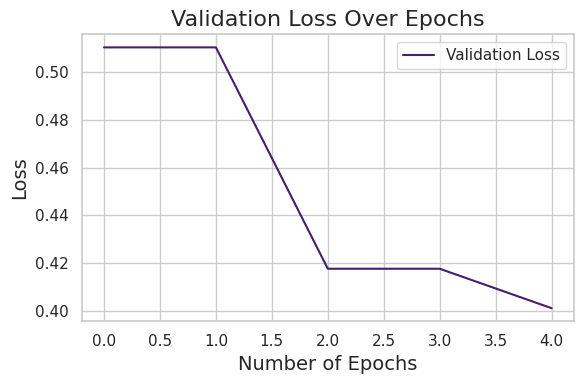

In [48]:
plt.figure(figsize=(6, 4))
# Plot validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color=palette[0], label="Validation Loss")
# Add titles and labels with improved styling
plt.title("Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step


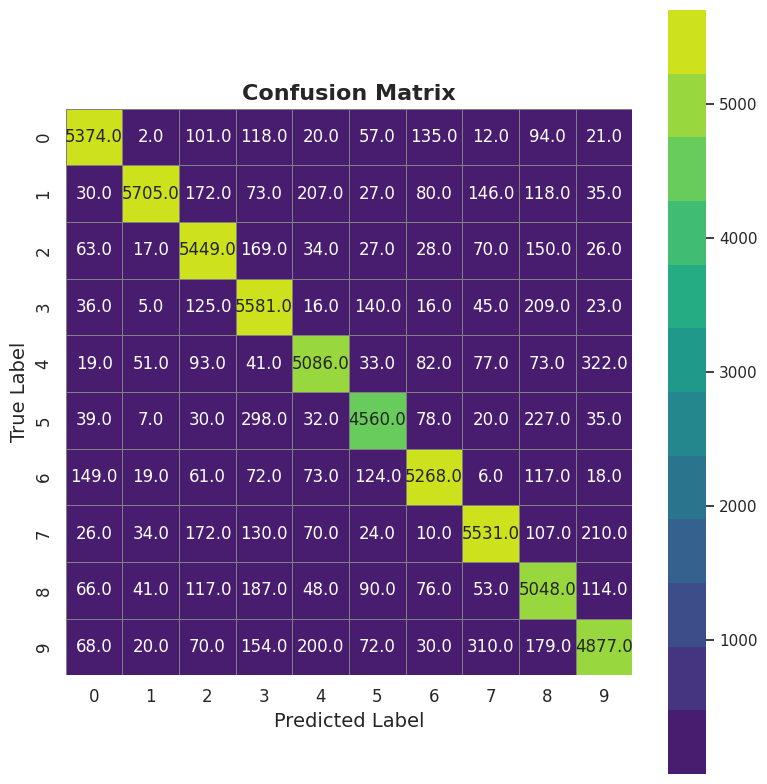

In [51]:
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Create the plot
plt.figure(figsize=(8, 8))

# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)

# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### **Model 2**